In [33]:
import numpy as np
import torch
from torch.autograd.functional import jacobian
import random

from qoptcraft.basis.algebra import *
from qoptcraft.invariant.invariant import *
from qoptcraft.math.mat_inner_product import *
from qoptcraft.basis import *
from qoptcraft.optical_elements import *
from qoptcraft.operators import *
from qoptcraft.evolution import *

from qoptcraft import get_photon_basis

from qoptcraft.state.state import PureState

from tqdm.notebook import tqdm
#from pqdm.processes import pqdm
#import multiprocess

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown
def printmd(x): return display(Markdown(x))


from functools import partial

def SinglePhotonHamiltonianBS(modes=4, mode_1=0, mode_2=1, gate_type='real'):
    

    if gate_type=='real':
        ## "real" beam-splitter ("acts like Pauli Y rotation")
        H = torch.zeros((modes,modes), dtype=torch.complex128)
        
        H[mode_1, mode_2] = -1j
        H[mode_2, mode_1] = +1j

    
    elif gate_type=='imaginary':
        ## "imaginary" beam-splitter ("acts like Pauli X rotation")
        H = torch.zeros((modes,modes), dtype=torch.complex128)
        
        H[mode_1, mode_2] = 1
        H[mode_2, mode_1] = 1

    return H



def HamiltonianBS(photons=2, modes=4, mode_1=0, mode_2=1, gate_type='real'):

    HS = SinglePhotonHamiltonianBS(modes, mode_1, mode_2, gate_type=gate_type)
    
    HU = photon_hamiltonian(HS, photons)
    HU = torch.tensor(HU, dtype=torch.complex128)

    return HU



def UnitaryBS(theta=torch.pi/4, photons=2, modes=4, mode_1=0, mode_2=1, gate_type='real'):
    
    HU = HamiltonianBS(photons, modes, mode_1, mode_2, gate_type=gate_type)
    U = torch.matrix_exp(-1j*HU * theta)
    
    return U











def complex_tensor_to_stacked_real_imaginary_tensor(T):
    #Convert a complex pytorch tensor into a real one, with one extra last dimension of size 2, corresponding to real and imaginary parts.
    
    real_part = T.real
    imag_part = T.imag

    combined_tensor = torch.stack((real_part, imag_part), dim=-1)

    return combined_tensor



def jacobian_complex_or_real(func, inputs, complex_or_real='complex', **kwargs):
    # If `complex_or_real`=='real',    reverts to Pytorch's usual jacobian(), but
    # if `complex_or_real`=='complex', handles jacobian for complex-pytorch-tensor valued function, by considering the stacked tensor of real and imaginary parts.

    if complex_or_real=='complex':
        
        def func_split(inp):
            output = func(inp)
            output_split = complex_tensor_to_stacked_real_imaginary_tensor(output)
            return output_split
    
        return jacobian(func_split, inputs, **kwargs)


    if complex_or_real=='real':

        def func_keepjustrealparts(inp):
            output = func(inp)
            output_justreal = output.real
            return output_justreal
        
        return jacobian(func_keepjustrealparts, inputs, **kwargs)
        




#source: https://github.com/ptitbroussou/HW_QCNN/blob/41d6aab797c97a43ea2084f1591dcf43bbfb373d/toolbox.py#L295
def Pyramidal_Order_RBS_gates(nbr_qubits, first_RBS = 0):
    """ This function gives the structure of each inner layer in the pyramidal
    quantum neural network. List_order gives the qubit link to each theta and
    List_layer_index gives the list of the theta for each inner layer. """
    List_layers, List_order, List_layer_index = [], [], []
    index_RBS = first_RBS
    # Beginning of the pyramid
    for i in range(nbr_qubits//2):
        list, list_index = [], []
        for j in range(i+1):
            if (i*2 < (nbr_qubits-1)):
                list.append(j*2)
                list_index.append(index_RBS)
                index_RBS += 1
        if (len(list) > 0):
            List_layers.append(list)
            List_layer_index.append(list_index)
        list, list_index = [], []
        for j in range(i+1):
            if (i*2 + 1 < (nbr_qubits-1)):
                list.append(j*2+1)
                list_index.append(index_RBS)
                index_RBS += 1
        if (len(list) > 0):
            List_layers.append(list)
            List_layer_index.append(list_index)
    # End of the pyramid
    for i in range(len(List_layers)-2, -1, -1):
        List_layers.append(List_layers[i])
        list_index = []
        for j in range(len(List_layers[i])):
            list_index.append(index_RBS)
            index_RBS += 1
        List_layer_index.append(list_index)
    # Deconcatenate:
    for i,layer in enumerate(List_layers):
        List_order += layer
    return(List_order, List_layer_index)


def pyramidal_BS_consecutive_pairs_of_modes(modes):
    return [ (i,i+1) for i in Pyramidal_Order_RBS_gates(modes)[0] ]


def pyramidal_BS_unitary_circuit(Th, modes=5, photons=1, gate_type='real'):

    dim_Orthogonal_matrices_modes = modes*(modes-1)//2

    pyramid_consectuive_pairs_of_modes = [ (i,i+1) for i in Pyramidal_Order_RBS_gates(modes)[0] ]

    assert len(Th) == dim_Orthogonal_matrices_modes
    assert len(pyramid_consectuive_pairs_of_modes) == dim_Orthogonal_matrices_modes

    
    d = hilbert_dim(modes, photons)
    
    U_circuit = torch.eye(d, dtype=torch.complex128)
    for i in range(dim_Orthogonal_matrices_modes):
        gate = UnitaryBS(Th[i], photons, modes,
                         mode_1=pyramid_consectuive_pairs_of_modes[i][0] ,
                         mode_2=pyramid_consectuive_pairs_of_modes[i][1],
                         gate_type=gate_type)
        U_circuit = gate @ U_circuit
    return U_circuit


def pyramidal_BS_circuit_list_of_unitaries(Th, modes=5, photons=1, gate_type='real'):

    dim_Orthogonal_matrices_modes = modes*(modes-1)//2

    pyramid_consectuive_pairs_of_modes = [ (i,i+1) for i in Pyramidal_Order_RBS_gates(modes)[0] ]

    assert len(Th) == dim_Orthogonal_matrices_modes
    assert len(pyramid_consectuive_pairs_of_modes) == dim_Orthogonal_matrices_modes

    
    d = hilbert_dim(modes, photons)
    
    list_of_unitaries = []
    for i in range(dim_Orthogonal_matrices_modes):
        gate = UnitaryBS(Th[i], photons, modes,
                         mode_1=pyramid_consectuive_pairs_of_modes[i][0] ,
                         mode_2=pyramid_consectuive_pairs_of_modes[i][1],
                         gate_type=gate_type)
        list_of_unitaries.append( gate ) 
    return list_of_unitaries


def pyramidal_BS_circuit_list_of_single_unitary_functions(modes=5, photons=1, gate_type='real'):

    dim_Orthogonal_matrices_modes = modes*(modes-1)//2

    pyramid_consectuive_pairs_of_modes = [ (i,i+1) for i in Pyramidal_Order_RBS_gates(modes)[0] ]


    assert len(pyramid_consectuive_pairs_of_modes) == dim_Orthogonal_matrices_modes

    
    d = hilbert_dim(modes, photons)
    
    list_of_single_unitary_functions = []
    for i in range(dim_Orthogonal_matrices_modes):
        
        unitary_function_i = (lambda th_i,
                                     photons=photons, modes=modes,
                                     mode_1=pyramid_consectuive_pairs_of_modes[i][0],
                                     mode_2=pyramid_consectuive_pairs_of_modes[i][1],
                                     gate_type=gate_type
                                     :
                                     UnitaryBS(th_i, photons, modes, mode_1, mode_2, gate_type)
                             )

        list_of_single_unitary_functions.append( unitary_function_i ) 
   
    return list_of_single_unitary_functions





def get_PVM_of_photon_count_at_mode(mode, modes, photons):
    """Returns the list of the `photons+1` orthogonal projectors that
    represent the photon-count measurement at the mode `mode`.
    They are returned in increasing order of photon-count."""
    
    d = hilbert_dim(modes, photons)
    fock_basis = get_photon_basis(modes, photons)
    
    #Reminder: the way QOptCraft orders the Fock basis when it builds n-photon hamiltonians
    # (in its method `photon_hamiltonian` that I use) is the order of the Python list returned
    # by `get_photon_basis`. So this convention is respected for the PVM built here.

    PVM_elements = [torch.zeros((d,d), dtype=torch.complex128) for _ in range(photons+1)]
    for i in range(d):
        k_of_this_basis_elem =  fock_basis[i][mode]
        PVM_elements[k_of_this_basis_elem][i,i] = 1 
    
    return PVM_elements

def get_PVM_measurement_quantum_channel(mode, modes, photons):
    return  ( lambda mat: sum(kraus_op @ mat @ kraus_op.conj().T for kraus_op in get_PVM_of_photon_count_at_mode(mode, modes, photons)) )

def get_depolarizing_quantum_channel(lambda_depolarizing_strength, d, input_assured_unittrace=True):
    if input_assured_unittrace:
        return  ( lambda mat: (1-lambda_depolarizing_strength)*mat  +  (lambda_depolarizing_strength)*(torch.eye(d)/d) )
    else:
        return  ( lambda mat: (1-lambda_depolarizing_strength)*mat  +  (lambda_depolarizing_strength)*torch.trace(mat)*(torch.eye(d)/d) )


def Unitary_to_QuantumChannel(unitary_matrix):
    return ( lambda mat, unitary_matrix=unitary_matrix: unitary_matrix @ mat @ unitary_matrix.conj().T )
    



def random_BS_circuit_list_of_channels(Th, modes=5, photons=3, random_pairs_of_modes=None, gate_type='real'):
    
    depth = len(Th)

    if random_pairs_of_modes is None:
        random_pairs_of_modes = [random.sample(range(modes), 2) for _ in range(depth)]
    
    list_of_quantum_channels = []
    for i in range(depth):
        unitary_matrix = UnitaryBS(Th[i], photons, modes, mode_1=random_pairs_of_modes[i][0] , mode_2=random_pairs_of_modes[i][1], gate_type=gate_type)
        list_of_quantum_channels.append( Unitary_to_QuantumChannel(unitary_matrix) )
        
    return list_of_quantum_channels


def pyramidal_random_interlaced_BS_circuit_list_of_channels(Th, modes=5, photons=3, N_rand=5 , gate_type='real'):
    # gives a list of quantum channels that are, successively, one pyramidal BS circuits, and `N_rand` single BeamSplitters.
    # Warning: for now, len(Th) must be exactly divisible by dim_Orthogonal_matrices_modes+N_rand
    
    dim_Orthogonal_matrices_modes = modes*(modes-1)//2
    
    depth = len(Th)

    K, R = divmod(depth, dim_Orthogonal_matrices_modes+N_rand)
    assert R==0
    
    list_of_quantum_channels = []

    for k in range(K):
        Ths_for_pyramidal = Th[k*(dim_Orthogonal_matrices_modes+N_rand) : k*(dim_Orthogonal_matrices_modes+N_rand) + dim_Orthogonal_matrices_modes]
        unitary_matrix_pyramidal = pyramidal_BS_unitary_circuit(Ths_for_pyramidal, modes, photons, gate_type=gate_type)
        list_of_quantum_channels.append( Unitary_to_QuantumChannel(unitary_matrix_pyramidal) )

        random_pairs_of_modes = [random.sample(range(modes), 2) for _ in range(N_rand)]
        for n_rand in range(N_rand):
            Th_for_random = Th[k*(dim_Orthogonal_matrices_modes+N_rand) + dim_Orthogonal_matrices_modes + n_rand]
            unitary_matrix_random = UnitaryBS(Th_for_random, photons, modes, mode_1=random_pairs_of_modes[n_rand][0] , mode_2=random_pairs_of_modes[n_rand][1], gate_type=gate_type)
            list_of_quantum_channels.append( Unitary_to_QuantumChannel(unitary_matrix_random) )
        
    return list_of_quantum_channels


def get_uniform_superposition_density_matrix(d):
    initial_state_ket = torch.ones(d, dtype=torch.complex128) / np.sqrt(d)
    initial_state_density_matrix = initial_state_ket.view((-1,1)) @ initial_state_ket.view((1,-1))  # psi @ psi^*
    return initial_state_density_matrix



def insert_elements_into_list_at_indices(L, elems, indices):
    """Returns a list that is the result of "inserting 'in parallel' into the list `L` all the elments `elem[i]` at location `indices[i]` in L (if it were the only element inserted in L)"""
    
    # sort the keys in reverse
    for k,v in sorted(zip(indices, elems), key=lambda x:x[0], reverse=True):
        L.insert(k, v)

    return L




def Jacobian_of_Output_Density_Matrix_with_Random_BS_and_measurement_channels(
    ## RUNS PARAMS ##
    number_architectures = 8,
    number_trials_per_architecture = 3,
    all_or_final = 'final', #whether to compute jacobians for `all` the intermediate quantum states, or just the `final` one.
    also_calculate_purities = False,
    custom_svdvals_absolute_tolerance = 1e-4, #if not None, the singular values <= this will be truncated to zero, for the rank calculation

    ## QUANTUM SETUP PARAMS ##
    gate_list = ['random_BS', 'random_BS', 'pyramid_of_BSs', ('mode_measurement', 0), 'random_BS', ('depolarizing', 0.2)],
    modes   = 5,
    photons = 1,
    gate_type = 'real', # can be: one of 'real', 'imaginary'.
    
    initial_state = 'uniform-superposition',
    verbose=1):
    ##################################################


    d = hilbert_dim(modes, photons)
    dim_Orthogonal_matrices_modes = modes*(modes-1)//2
    

    def final_state_density_matrix(Th, architecture, stop_at_step=False):
    
        initial_state_density_matrix, full_list_of_single_step_quantum_channels_functions_and_type = architecture

        state = initial_state_density_matrix
        
        next_unused_parameter_index = 0
        step = 0
        for quantum_channel_function, channel_type in full_list_of_single_step_quantum_channels_functions_and_type:
            if stop_at_step and step==stop_at_step:
                break

            
            if channel_type=='fixed':
                quantum_channel = quantum_channel_function
            elif channel_type=='parametrized':
                quantum_channel = quantum_channel_function(Th[next_unused_parameter_index])
                next_unused_parameter_index += 1

            state = quantum_channel(state)
            
            step += 1
        return state


        
        


    number_params = 0
    total_number_gates = 0
    final_positions_of_added_gates = []
    for i,gate_instruction in enumerate(gate_list):
        
        if gate_instruction == 'random_BS':
            number_params += 1
            total_number_gates += 1
        
        elif gate_instruction == 'pyramid_of_BSs':
            number_params += dim_Orthogonal_matrices_modes
            total_number_gates += dim_Orthogonal_matrices_modes
                    
        elif (isinstance(gate_instruction, tuple) or isinstance(gate_instruction, list)) and (gate_instruction[0] in ['mode_measurement', 'depolarizing']):
            final_positions_of_added_gates.append( total_number_gates )
            number_params += 0
            total_number_gates += 1
            

    Results = {}
    Results['number_params'] = number_params
    Results['total_number_gates'] = total_number_gates
    Results['final_positions_of_added_gates'] = final_positions_of_added_gates

    
    if verbose>=0:
        printmd(f"Dimension of single-photon Hilbert space: $\dim(\mathcal{{H}}_{{({modes}\mathrm{{\ modes}},{1}\mathrm{{\ photon}})}})={modes}$.")
        printmd(f"Dimension of global Hilbert space: $\dim(\mathcal{{H}}_{{({modes}\mathrm{{\ modes}},{photons}\mathrm{{\ photons}})}})={d}$.")
        printmd(f"Dimension of (space of *pure* {d}x{d} density-matrices): $\dim(\mathrm{{PureStates}}({d}))={2*d-2}$.")
        printmd(f"Dimension of Parameter space: $\dim(\Theta)={number_params}$.")
        printmd(f"(Maximal-Local-)Dimension of (space of all {d}x{d} density-matrices): $\dim(\mathrm{{States}}({d}))={d**2 - 1}$.")
        printmd(f"Dimension of (space of (det1-)orthogonal {modes}x{modes} matrices): $\dim(\mathrm{{SO}}({modes}))=\dim(\mathrm{{O}}({modes}))={dim_Orthogonal_matrices_modes}$.")
        printmd(f"Dimension of (space of (det1-)orthogonal {d}x{d} matrices): $\dim(\mathrm{{SO}}({d}))=\dim(\mathrm{{O}}({d}))={dim_Orthogonal_matrices_modes}$.")
        printmd(f"Dimension of (Orbit of any (non-maximally-mixed) {d}x{d} density matrix under orthogonal action): $\dim(\mathrm{{O}}({d}) \cdot \\rho)={d-1}$.") 
        printmd(f"Dimension of (Orbit of any (non-maximally-mixed) {modes}x{modes} density matrix under orthogonal action): $\dim(\mathrm{{O}}({modes}) \cdot \\rho)={modes-1}$.") 
    



    def BS_unitary_channel_function_maker(mode_1, mode_2):
        def BS_unitary_channel_function(th):
            return Unitary_to_QuantumChannel( UnitaryBS(theta=th, photons=photons, modes=modes, mode_1=mode_1, mode_2=mode_2, gate_type=gate_type) )
        return BS_unitary_channel_function

    #for archicture_run_index in tqdm(range(number_architectures), disable=False):  
    def main(archicture_run_index):
        Results =  {}
        if verbose>=1: print(f"Random-architecture index: {archicture_run_index}")
    
        ### Specify the initial quantum state `initial_state_density_matrix`:
        if isinstance(initial_state, str) and  initial_state == 'uniform-superposition':
            initial_state_density_matrix = get_uniform_superposition_density_matrix(d)

        if isinstance(initial_state, tuple) and len(initial_state)==d:
            #Assume the initial is provided as a Fock basis element tuple (i.e. an element of `get_photon_basis(modes, photons)`)
            
            fock_basis = get_photon_basis(modes, photons)
            initial_state_basis_index = fock_basis.index(initial_state)
            initial_state_ket = torch.zeros(d, dtype=torch.complex128)
            initial_state_ket[ initial_state_basis_index ] = 1
            initial_state_density_matrix = initial_state_ket.view((-1,1)) @ initial_state_ket.view((1,-1))  # psi @ psi^*

        
        if isinstance(initial_state, int) and 0 <= initial_state <= d-1:
            #Assume the initial is provided as an (0-starting-)index in the Fock basis list (i.e. an index position in `get_photon_basis(modes, photons)`)
            
            fock_basis = get_photon_basis(modes, photons)
            initial_state_basis_index = initial_state
            initial_state_ket = torch.zeros(d, dtype=torch.complex128)
            initial_state_ket[ initial_state_basis_index ] = 1
            initial_state_density_matrix = initial_state_ket.view((-1,1)) @ initial_state_ket.view((1,-1))  # psi @ psi^*


        if isinstance(initial_state, PureState):
            #Assume the initial is provided as a Fock basis element QOptCraft PureState object (e.g. obtained through  `Fock(amplitude_1,...,amplitude_M)`)
            initial_state_density_matrix = torch.tensor(initial_state.density_matrix)

        
        initial_state_density_matrix = initial_state_density_matrix + 0j



        
        full_list_of_single_step_quantum_channels_functions_and_type = []
        for gate_instruction in gate_list:
            if gate_instruction == 'random_BS':
                
                # Draw random ordered-pair of (non-indentical) modes to place a Beam-Splitter at:
                random_pair_of_modes = random.sample(range(modes), 2)

                unitary_matrix_function  = lambda th, photons=photons, modes=modes, mode_1=random_pair_of_modes[0], mode_2=random_pair_of_modes[1], gate_type=gate_type: UnitaryBS(theta=th, photons=photons, modes=modes, mode_1=mode_1, mode_2=mode_2, gate_type=gate_type)

                
                #unitary_channel_function = lambda th: Unitary_to_QuantumChannel(unitary_matrix_function(th))

                unitary_channel_function = BS_unitary_channel_function_maker(random_pair_of_modes[0], random_pair_of_modes[1])
                
                full_list_of_single_step_quantum_channels_functions_and_type.append( (unitary_channel_function, 'parametrized') )
                
            elif gate_instruction == 'pyramid_of_BSs':

                list_of_single_unitary_channels_functions_pyramid = [ BS_unitary_channel_function_maker(mode_1, mode_2) for mode_1,mode_2 in pyramidal_BS_consecutive_pairs_of_modes(modes) ]
                list_of_single_unitary_channels_functions_and_type_pyramid = [(channel_func, 'parametrized') for channel_func in list_of_single_unitary_channels_functions_pyramid]
                
                
                full_list_of_single_step_quantum_channels_functions_and_type.extend( list_of_single_unitary_channels_functions_and_type_pyramid )

            elif (isinstance(gate_instruction, tuple) or isinstance(gate_instruction, list)) and gate_instruction[0] == 'mode_measurement':
                measured_mode = gate_instruction[1]
                state_injection_channel = get_PVM_measurement_quantum_channel(measured_mode, modes, photons)

                full_list_of_single_step_quantum_channels_functions_and_type.append( (state_injection_channel, 'fixed') )

            elif (isinstance(gate_instruction, tuple) or isinstance(gate_instruction, list)) and gate_instruction[0] == 'depolarizing':
                lambda_depolarizing_strength = gate_instruction[1]
                depolarizing_channel = get_depolarizing_quantum_channel(lambda_depolarizing_strength, d)

                full_list_of_single_step_quantum_channels_functions_and_type.append( (depolarizing_channel, 'fixed') )

        
        
        current_architecture = [ initial_state_density_matrix, full_list_of_single_step_quantum_channels_functions_and_type ]
       
        Results[archicture_run_index] = {
                                         'Ths': [],
                                         'ranks_jacobian_RhoOut': [],
                                         'ranks_jacobian_Rhos': [],
                                         'svdvals_jacobian_RhoOut': [],
                                         'svdvals_jacobian_Rhos': [],
                                         'purities_Rhos': []}


        #Choose now which jacobian routine (complex or real) will be used:
        if gate_type=='imaginary': complex_or_real = 'complex'
        if gate_type=='real':      complex_or_real = 'real'

        
        
        initial_state_is_entrywise_real = (not torch.is_complex(initial_state_density_matrix)) or torch.all(torch.abs(initial_state_density_matrix.imag) < 1e-4)
        
        if gate_type=='real' and not initial_state_is_entrywise_real:
            print("WARNING! For now, since the photonic gate specified is real, the code for the jacobians currently throws away the imaginary part of the input density matrix (to be twice as fast), because usually the input state is all real as well. But here the supplied input state wasn't all real.. so the jacobian ranks are not to be trusted.")

        
        for _ in tqdm(range(number_trials_per_architecture), leave=False, disable=False):
    
            ### Draw the random Theta parameter vector:
            Th_random_values = torch.rand(number_params)*(2*torch.pi)
            Th_random = Th_random_values.clone().detach().requires_grad_(True)        
    
            if all_or_final=='final':
                ### Calculate Jacobian of final state density matrix, using pytorch differentiation:
                Jacobian_final_state_Th = jacobian_complex_or_real(lambda Th: final_state_density_matrix(Th, current_architecture), Th_random, complex_or_real=complex_or_real, create_graph=True)
                Jacobian_vectorized_final_state_Th = Jacobian_final_state_Th.view(-1, number_params)

                ### Get rank of that Jacobian matrix:
                try:
                    if custom_svdvals_absolute_tolerance:
                        rank = int( torch.linalg.matrix_rank(Jacobian_vectorized_final_state_Th, atol=custom_svdvals_absolute_tolerance) )
                    else:
                        rank = int( torch.linalg.matrix_rank(Jacobian_vectorized_final_state_Th) )
                    if verbose>=2: print(f"rank: {rank}")

                    singular_values = torch.linalg.svdvals(Jacobian_vectorized_final_state_Th).detach().numpy()
                except torch.linalg.LinAlgError:
                    rank = 'LinAlgError'
                Results[archicture_run_index]['ranks_jacobian_RhoOut'].append( rank )
                Results[archicture_run_index]['Ths'].append( Th_random_values )
                Results[archicture_run_index]['svdvals_jacobian_RhoOut'].append( singular_values )

            if all_or_final=='all':
                ### Calculate Jacobian of each intermediate density matrix, each time redoing the whole Pytorch task (very inefficient):

                Results[archicture_run_index]['ranks_jacobian_Rhos'].append({})
                Results[archicture_run_index]['svdvals_jacobian_Rhos'].append({})
                if also_calculate_purities:
                    Results[archicture_run_index]['purities_Rhos'].append({})
                for step in tqdm(range(1, total_number_gates +1), leave=False, disable=False):


                    current_density_matrix_function = partial( final_state_density_matrix, architecture=current_architecture, stop_at_step=step )
                    
                    Jacobian_intermediate_state_Th = jacobian_complex_or_real(current_density_matrix_function, Th_random, complex_or_real=complex_or_real, create_graph=True)

                    
                    Jacobian_vectorized_intermediate_state_Th = Jacobian_intermediate_state_Th.view(-1, number_params)

                    ### Get rank of that Jacobian matrix:
                    try:
                        if custom_svdvals_absolute_tolerance:
                            rank = int( torch.linalg.matrix_rank(Jacobian_vectorized_intermediate_state_Th, atol=custom_svdvals_absolute_tolerance) )
                        else:
                            rank = int( torch.linalg.matrix_rank(Jacobian_vectorized_intermediate_state_Th) )
                        if verbose>=2: print(f"rank: {rank}")

                        singular_values = torch.linalg.svdvals(Jacobian_vectorized_intermediate_state_Th).detach().numpy()
                    except torch.linalg.LinAlgError:
                        rank = 'LinAlgError'

                    
                    Results[archicture_run_index]['ranks_jacobian_Rhos'][-1][step] = rank
                    Results[archicture_run_index]['svdvals_jacobian_Rhos'][-1][step] = singular_values

                    
                    if also_calculate_purities:
                        with torch.no_grad():
                            intermediate_state_Th = final_state_density_matrix(Th_random, current_architecture, stop_at_step=step)

                            purity = torch.trace(intermediate_state_Th @ intermediate_state_Th)
                            Results[archicture_run_index]['purities_Rhos'][-1][step] = np.float64(purity)
                        

                
                Results[archicture_run_index]['Ths'].append( Th_random_values )

        return Results[archicture_run_index]

    
    args = range(number_architectures)

    #parallelized_results = pqdm(args, main, n_jobs=4)

    #pool = multiprocess.Pool(4)
    #parallelized_results = pool.map(main, args)

    ##Leave it Unparallelized for now...
    parallelized_results = []
    for archicture_run_index in tqdm(args, disable=False):
        parallelized_results.append( main(archicture_run_index) ) 

    
    for i,archicture_run_index in enumerate(args):
        Results[archicture_run_index] = parallelized_results[i]


        
    if all_or_final=='final':
        for archicture_run_index in range(number_architectures):
            if verbose>=1:
                print( f"rank_jacobian_RhoOut obtained for architecture {archicture_run_index}: {Results[archicture_run_index]['ranks_jacobian_RhoOut']}" )
                print( f"detail of singular values obtained: {Results[archicture_run_index]['svdvals_jacobian_RhoOut']}" )
            
            
            

    
    if all_or_final=='all':
        all_rank_histories = []
        for architecture_i in range(number_architectures):
            all_rank_histories += [ list(successive_ranks.values()) for successive_ranks in Results[architecture_i]['ranks_jacobian_Rhos'] ]

        Results['all_rank_histories'] = all_rank_histories
        
        
        if also_calculate_purities:
            all_purity_histories = []
            for architecture_i in range(number_architectures):
                all_purity_histories += [ list(successive_purities.values()) for successive_purities in Results[architecture_i]['purities_Rhos'] ]
    
            Results['all_purity_histories'] = all_purity_histories
        
       
        if verbose>=1:
            print("all_rank_histories:")
            print(*all_rank_histories, sep='\n')

            print("all_purity_histories:")
            print(*all_purity_histories, sep='\n')
        

    if all_or_final=='all':
        ####Plot rank evolution
        sns.set_theme(style="darkgrid")
        fig = plt.figure(figsize=(0.25*(Results['total_number_gates'] +1), 4))
        for rank_history in Results['all_rank_histories']:
            sns.lineplot(x=list(range(1, Results['total_number_gates'] +1)), y=rank_history, marker='.', alpha=0.6)
            plt.xlabel('Intermediate step $i$ of quantum circuit')
            plt.ylabel(r'$\mathrm{rank}[Jacobian \, ( \rho_{\text{step\ }i} )(\theta)]$')
        
        ymax = max([max(rank_history) for rank_history in Results['all_rank_histories']])
        for position_of_added_gate in Results['final_positions_of_added_gates']:
            plt.axvline(x=position_of_added_gate + 0.5, ymin=0, ymax=(ymax-1), linestyle='solid', linewidth=1.5, color='green', alpha=0.2)
        
        plt.xticks(list(range(0, Results['total_number_gates'] +1)), fontsize=8)
        plt.yticks(list(range(0, ymax +2, 2)), fontsize=9)

        gate_list_inserted_only = [gate_instruction for gate_instruction in gate_list if (isinstance(gate_instruction, tuple) or isinstance(gate_instruction, list))]
        if all( inserted_gate_instruction[0]=='mode_measurement' for inserted_gate_instruction in gate_list_inserted_only ) and len(set( inserted_gate_instruction[1] for inserted_gate_instruction in gate_list_inserted_only))==1:
            title_gate_insereted = f"mode-measurement--{gate_list_inserted_only[0][1]}"
        elif all( inserted_gate_instruction[0]=='depolarizing' for inserted_gate_instruction in gate_list_inserted_only ) and len(set( inserted_gate_instruction[1] for inserted_gate_instruction in gate_list_inserted_only))==1:
            title_gate_insereted = f"depolarizing--{gate_list_inserted_only[0][1]}"
        else:
            title_gate_insereted = f"(many)"
    
        
        title_string = f'$m={modes}$, $n={photons}$, gate_inserted={title_gate_insereted}, initial_state={initial_state}, architectures={number_architectures}, trials_per_architecture={number_trials_per_architecture}'
        short_title_string=title_string[:30]
        plt.title(title_string)
        
        plt.show()
        fig.savefig(f'{short_title_string}.pdf')
    
        Results['fig'] = fig
    
        ## same plot, put just looking at the evolution of purities, instead of rank-of-Jacobians:
        if also_calculate_purities:
            fig = plt.figure(figsize=(0.25*(Results['total_number_gates'] +1), 4))
            for purity_history in Results['all_purity_histories']:
                sns.lineplot(x=list(range(1, Results['total_number_gates'] +1)), y=purity_history, marker='.', alpha=0.6)
                plt.xlabel('Intermediate step $i$ of quantum circuit')
                plt.ylabel(r'$Purity \, ( \rho_{\text{step\ }i} )(\theta)$')
            
            for position_of_added_gate in Results['final_positions_of_added_gates']:
                plt.axvline(x=position_of_added_gate + 0.5, ymin=0, ymax=1, linestyle='solid', linewidth=1.5, color='green', alpha=0.2)
            
            plt.xticks(list(range(0, Results['total_number_gates'] +1)), fontsize=8)
            plt.ylim(0, 1)
            
            plt.title(title_string)
            
            plt.show()
            fig.savefig(f'{short_title_string}_purities.pdf')
        
            Results['fig_purity'] = fig
    ####
    
    return Results

Dimension of single-photon Hilbert space: $\dim(\mathcal{H}_{(4\mathrm{\ modes},1\mathrm{\ photon})})=4$.

Dimension of global Hilbert space: $\dim(\mathcal{H}_{(4\mathrm{\ modes},2\mathrm{\ photons})})=10$.

Dimension of (space of *pure* 10x10 density-matrices): $\dim(\mathrm{PureStates}(10))=18$.

Dimension of Parameter space: $\dim(\Theta)=30$.

(Maximal-Local-)Dimension of (space of all 10x10 density-matrices): $\dim(\mathrm{States}(10))=99$.

Dimension of (space of (det1-)orthogonal 4x4 matrices): $\dim(\mathrm{SO}(4))=\dim(\mathrm{O}(4))=6$.

Dimension of (space of (det1-)orthogonal 10x10 matrices): $\dim(\mathrm{SO}(10))=\dim(\mathrm{O}(10))=6$.

Dimension of (Orbit of any (non-maximally-mixed) 10x10 density matrix under orthogonal action): $\dim(\mathrm{O}(10) \cdot \rho)=9$.

Dimension of (Orbit of any (non-maximally-mixed) 4x4 density matrix under orthogonal action): $\dim(\mathrm{O}(4) \cdot \rho)=3$.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

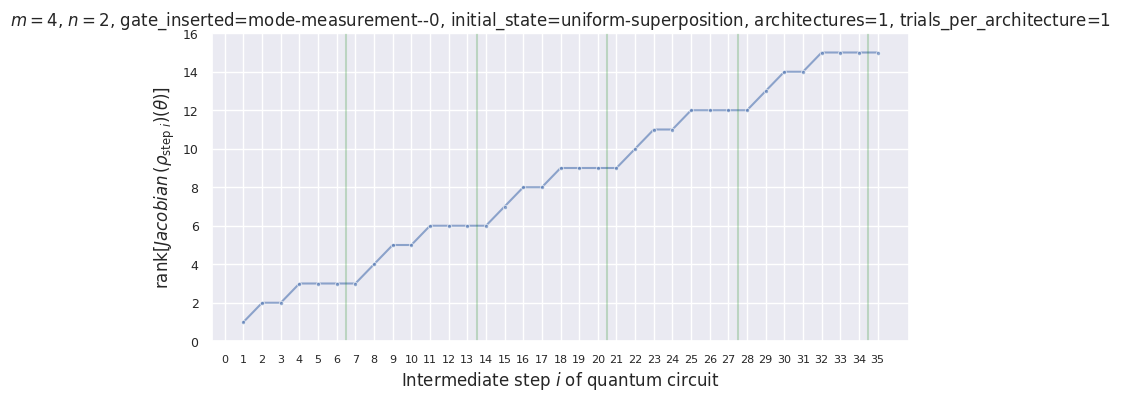

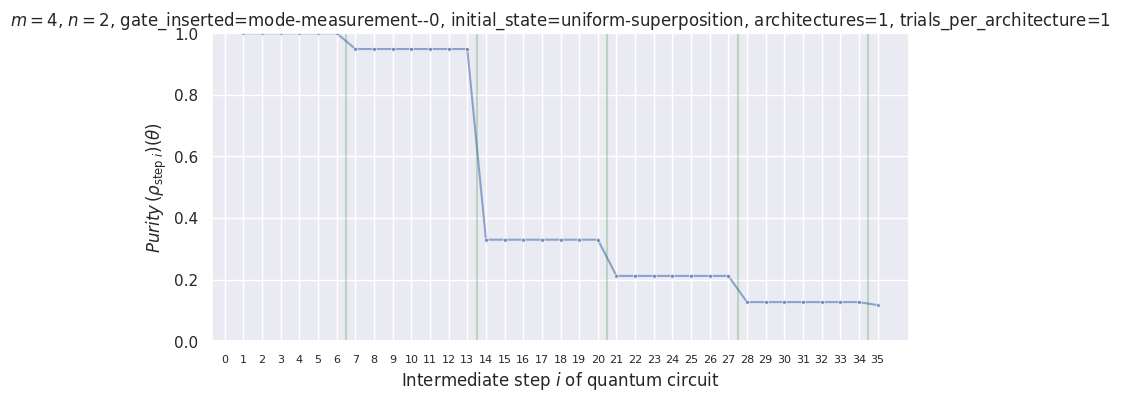

['pyramid_of_BSs', ('mode_measurement', 0), 'pyramid_of_BSs', ('mode_measurement', 0), 'pyramid_of_BSs', ('mode_measurement', 0), 'pyramid_of_BSs', ('mode_measurement', 0), 'pyramid_of_BSs', ('mode_measurement', 0)]


In [45]:
###########################################################

##########################
modes = 4
photons = 2
number_of_pyramidalplusrandom = 5
N_rand_after_pyramidal = 0
##########################


#gate_list = ['random_BS', 'random_BS', 'pyramid_of_BSs', ('mode_measurement', 0), 'random_BS', ('depolarizing', 0.2)]


gate_list = []
for i in range(number_of_pyramidalplusrandom):
    
    gate_list.append('pyramid_of_BSs')
    
    for j in range(N_rand_after_pyramidal):
        gate_list.append('random_BS')


    gate_list.append( ('mode_measurement', 0) )
    #gate_list.append( ('depolarizing', 0.2) )
    




Results = Jacobian_of_Output_Density_Matrix_with_Random_BS_and_measurement_channels(
    
    ## RUNS PARAMS ##
    number_architectures = 1,
    number_trials_per_architecture = 1,
    all_or_final='all',
    also_calculate_purities=True,
    custom_svdvals_absolute_tolerance = 1e-4,

    ## QUANTUM SETUP PARAMS ##
    gate_list = gate_list,
    modes   = modes,
    photons = photons,
    gate_type = 'real', # can be: one of 'real', 'imaginary'.
        
    initial_state = 'uniform-superposition',
    #initial_state = 0,
    verbose=0)

print(gate_list)

In [46]:
gate_list

['pyramid_of_BSs',
 ('mode_measurement', 0),
 'pyramid_of_BSs',
 ('mode_measurement', 0),
 'pyramid_of_BSs',
 ('mode_measurement', 0),
 'pyramid_of_BSs',
 ('mode_measurement', 0),
 'pyramid_of_BSs',
 ('mode_measurement', 0)]